In [3]:
import os
import kagglehub
import pandas as pd
import glob
import tensorflow as tf
import mlflow
import datetime
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import numpy as np
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50,VGG16,EfficientNetB0
from keras.models import load_model
from tensorflow.keras.preprocessing import image
from keras.saving import save_model
import pickle
import webbrowser

c:\Users\shanm\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
pip install plotly


  Using cached narwhals-2.0.1-py3-none-any.whl.metadata (11 kB)
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.6 MB 326.8 kB/s eta 0:00:30
   ---------------------------------------- 0.1/9.6 MB 465.5 kB/s eta 0:00:21
    --------------------------------------- 0.1/9.6 MB 708.1 kB/s eta 0:00:14
   - -------------------------------------- 0.3/9.6 MB 1.3 MB/s eta 0:00:08
   -- ------------------------------------- 0.6/9.6 MB 2.1 MB/s eta 0:00:05
   --- ------------------------------------ 0.9/9.6 MB 2.7 MB/s eta 0:00:04
   ----- ---------------------------------- 1.2/9.6 MB 3.4 MB/s eta 0:00:03
   ------ --------------------------------- 1.5/9.6 MB 3.7 MB/s eta 0:00:03
   -------- ------------------------------- 1.

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
# Download dataset
path = kagglehub.dataset_download("yasserhessein/tuberculosis-chest-x-rays-images")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\shanm\.cache\kagglehub\datasets\yasserhessein\tuberculosis-chest-x-rays-images\versions\2


In [5]:
base_path = r"C:\Users\shanm\.cache\kagglehub\datasets\yasserhessein\tuberculosis-chest-x-rays-images\versions\2"

# List subdirectories inside the base path
subdirs = [os.path.join(base_path, name) for name in os.listdir(base_path) 
           if os.path.isdir(os.path.join(base_path, name))]

print("Subfolders found:", subdirs)

Subfolders found: ['C:\\Users\\shanm\\.cache\\kagglehub\\datasets\\yasserhessein\\tuberculosis-chest-x-rays-images\\versions\\2\\Dataset of Tuberculosis Chest X-rays Images']


In [6]:
dataset_root = r"C:\Users\shanm\.cache\kagglehub\datasets\yasserhessein\tuberculosis-chest-x-rays-images\versions\2\Dataset of Tuberculosis Chest X-rays Images"
print("Contents:", os.listdir(dataset_root))

Contents: ['Normal Chest X-rays', 'TB Chest X-rays']


In [7]:
dataset_root = r"C:\Users\shanm\.cache\kagglehub\datasets\yasserhessein\tuberculosis-chest-x-rays-images\versions\2\Dataset of Tuberculosis Chest X-rays Images"

tb_dir = os.path.join(dataset_root, "TB Chest X-rays")
normal_dir = os.path.join(dataset_root, "Normal Chest X-rays")


In [8]:
# Create labeled data lists
tb_data = [{"filepath": path, "label": 1} for path in glob.glob(os.path.join(tb_dir, "*.jpg"))]
normal_data = [{"filepath": path, "label": 0} for path in glob.glob(os.path.join(normal_dir, "*.jpg"))]

# Combine into DataFrame
df_tb = pd.DataFrame(tb_data)
df_normal = pd.DataFrame(normal_data)

# ✅ Combine and shuffle
df= pd.concat([df_tb, df_normal], ignore_index=True)

In [8]:
df

,filepath,label
0,C:\Users\shanm\.cache\kagglehub\datasets\yasse...,1
1,C:\Users\shanm\.cache\kagglehub\datasets\yasse...,1
2,C:\Users\shanm\.cache\kagglehub\datasets\yasse...,1
3,C:\Users\shanm\.cache\kagglehub\datasets\yasse...,1
4,C:\Users\shanm\.cache\kagglehub\datasets\yasse...,1
...,...,...
3003,C:\Users\shanm\.cache\kagglehub\datasets\yasse...,0
3004,C:\Users\shanm\.cache\kagglehub\datasets\yasse...,0
3005,C:\Users\shanm\.cache\kagglehub\datasets\yasse...,0
3006,C:\Users\shanm\.cache\kagglehub\datasets\yasse...,0


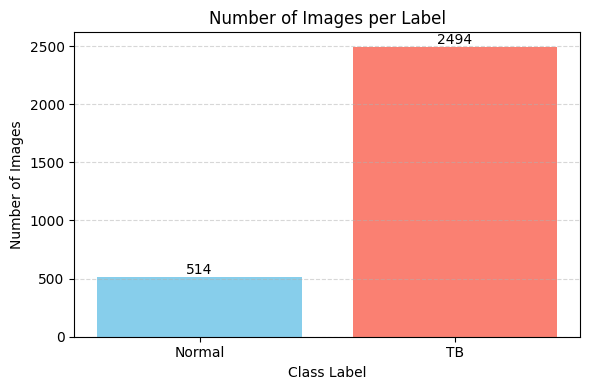

In [14]:
import matplotlib.pyplot as plt

# Count the number of samples per label
label_counts = df['label'].value_counts().sort_index()

# Define label names
label_names = {0: 'Normal', 1: 'TB'}

# Plot
plt.figure(figsize=(6, 4))
bars = plt.bar(label_counts.index.map(label_names), label_counts.values, color=['skyblue', 'salmon'])

# Add value labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval), ha='center', va='bottom')

# Customize
plt.title('Number of Images per Label')
plt.xlabel('Class Label')
plt.ylabel('Number of Images')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

In [12]:
df_tb = df[df['label'] == 1]
df_normal = df[df['label'] == 0]

In [15]:
# Augmentation settings
augmenter = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [16]:
IMG_SIZE = (224, 224)
target_count = len(df_tb)
augmented_images = []
augmented_labels = []

# How many more images we need
needed = target_count - len(df_normal)

# Loop through normal images and augment
i = 0
while len(augmented_images) < needed:
    img_path = df_normal.iloc[i % len(df_normal)]['filepath']
    img = load_img(img_path, target_size=IMG_SIZE, color_mode='grayscale')
    x = img_to_array(img).reshape((1,) + IMG_SIZE + (1,))
    
    # Generate one augmented image
    for batch in augmenter.flow(x, batch_size=1):
        augmented_images.append(batch[0])
        augmented_labels.append(0)
        break  # Only one per original image
    i += 1

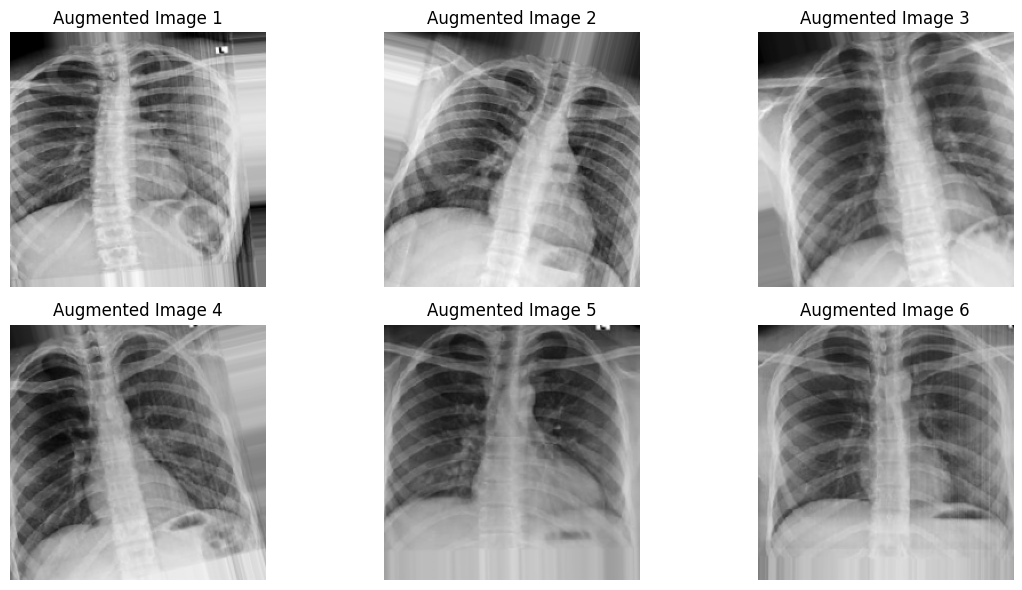

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for i in range(min(6, len(augmented_images))):  # Only loop through available images
    plt.subplot(2, 3, i + 1)
    img = augmented_images[i].reshape(IMG_SIZE)
    plt.imshow(img, cmap='gray')
    plt.title(f"Augmented Image {i + 1}")
    plt.axis('off')  # Optional: hides axis ticks

plt.tight_layout()
plt.show()

In [19]:
# Original images
X_tb = np.array([img_to_array(load_img(fp, target_size=IMG_SIZE, color_mode='grayscale')) / 255.0 for fp in df_tb['filepath']])
y_tb = np.ones(len(X_tb))

X_normal = np.array([img_to_array(load_img(fp, target_size=IMG_SIZE, color_mode='grayscale')) / 255.0 for fp in df_normal['filepath']])
y_normal = np.zeros(len(X_normal))

# Combine all
X_all = np.concatenate([X_tb, X_normal, np.array(augmented_images)])
y_all = np.concatenate([y_tb, y_normal, np.array(augmented_labels)])

# Reshape for model input
X_all = X_all.reshape(-1, IMG_SIZE[0], IMG_SIZE[1], 1)

In [20]:
# Original file paths
original_paths = list(df_tb['filepath']) + list(df_normal['filepath'])

# Augmented images don't have file paths, so we label them as 'augmented'
augmented_paths = ['augmented'] * len(augmented_images)

# Combine all paths
all_paths = original_paths + augmented_paths

In [21]:
# Create DataFrame
df_balanced = pd.DataFrame({
    'filepath': all_paths,
    'label': y_all.astype(int)
})

In [22]:
print(df_balanced.head())
print(df_balanced['label'].value_counts())

                                            filepath  label
0  C:\Users\shanm\.cache\kagglehub\datasets\yasse...      1
1  C:\Users\shanm\.cache\kagglehub\datasets\yasse...      1
2  C:\Users\shanm\.cache\kagglehub\datasets\yasse...      1
3  C:\Users\shanm\.cache\kagglehub\datasets\yasse...      1
4  C:\Users\shanm\.cache\kagglehub\datasets\yasse...      1
label
1    2494
0    2494
Name: count, dtype: int64


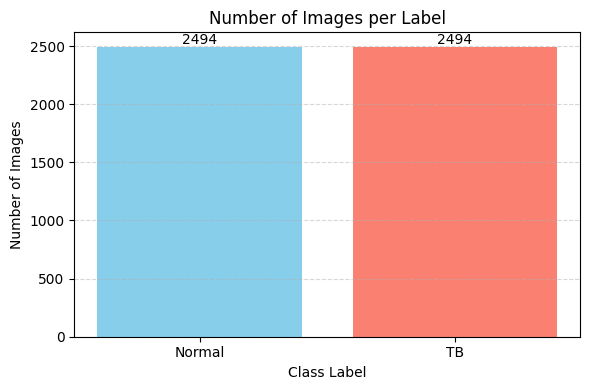

In [23]:
import matplotlib.pyplot as plt

# Count the number of samples per label
label_counts = df_balanced['label'].value_counts().sort_index()

# Define label names
label_names = {0: 'Normal', 1: 'TB'}

# Plot
plt.figure(figsize=(6, 4))
bars = plt.bar(label_counts.index.map(label_names), label_counts.values, color=['skyblue', 'salmon'])

# Add value labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval), ha='center', va='bottom')

# Customize
plt.title('Number of Images per Label')
plt.xlabel('Class Label')
plt.ylabel('Number of Images')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

In [ ]:
IMG_SIZE = (224, 224)

# Separate filepaths and labels
filepaths = df_balanced['filepath'].tolist()
labels = df_balanced['label'].tolist()

# Load images
X = []
for path in filepaths:
    if path == 'augmented':
        # Use preprocessed augmented image from earlier
        # (Assumes you still have `augmented_images` in memory)
        X.append(augmented_images.pop(0))
    else:
        img = load_img(path, target_size=IMG_SIZE, color_mode='grayscale')
        img_array = img_to_array(img) / 255.0
        X.append(img_array)

# Convert to NumPy arrays
X = np.array(X).reshape(-1, IMG_SIZE[0], IMG_SIZE[1], 1)
y = np.array(labels)

In [16]:
# Convert grayscale (1 channel) to RGB (3 channels) by duplicating channels
X_rgb = np.repeat(X, 3, axis=-1)  # Shape becomes (N, 224, 224, 3)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_rgb, y, test_size=0.2, stratify=y, random_state=42)

In [17]:
X_train

array([[[[1.50000000e+01, 1.50000000e+01, 1.50000000e+01],
         [1.58580322e+01, 1.58580322e+01, 1.58580322e+01],
         [1.67509861e+01, 1.67509861e+01, 1.67509861e+01],
         ...,
         [9.08369675e+01, 9.08369675e+01, 9.08369675e+01],
         [9.01696396e+01, 9.01696396e+01, 9.01696396e+01],
         [8.95023041e+01, 8.95023041e+01, 8.95023041e+01]],

        [[1.50000000e+01, 1.50000000e+01, 1.50000000e+01],
         [1.56148682e+01, 1.56148682e+01, 1.56148682e+01],
         [1.65078220e+01, 1.65078220e+01, 1.65078220e+01],
         ...,
         [8.75733490e+01, 8.75733490e+01, 8.75733490e+01],
         [8.44591370e+01, 8.44591370e+01, 8.44591370e+01],
         [8.13449173e+01, 8.13449173e+01, 8.13449173e+01]],

        [[1.50000000e+01, 1.50000000e+01, 1.50000000e+01],
         [1.53717041e+01, 1.53717041e+01, 1.53717041e+01],
         [1.62646580e+01, 1.62646580e+01, 1.62646580e+01],
         ...,
         [7.44690475e+01, 7.44690475e+01, 7.44690475e+01],
         [

2025/08/04 11:48:21 INFO mlflow.tracking.fluent: Experiment with name 'TB Detection with TransferLearning' does not exist. Creating a new experiment.


Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.8042 - loss: 0.3728 

125/125 ━━━━━━━━━━━━━━━━━━━━ 1646s 13s/step - accuracy: 0.8049 - loss: 0.3716 - val_accuracy: 0.9499 - val_loss: 0.1174
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9587 - loss: 0.1127

125/125 ━━━━━━━━━━━━━━━━━━━━ 1254s 10s/step - accuracy: 0.9587 - loss: 0.1127 - val_accuracy: 0.9729 - val_loss: 0.0836
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9721 - loss: 0.0825

125/125 ━━━━━━━━━━━━━━━━━━━━ 826s 7s/step - accuracy: 0.9721 - loss: 0.0824 - val_accuracy: 0.9770 - val_loss: 0.0626
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9777 - loss: 0.0678

125/125 ━━━━━━━━━━━━━━━━━━━━ 821s 7s/step - accuracy: 0.9778 - loss: 0.0677 - val_accuracy: 0.9830 - val_loss: 0.0571
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9816 - loss: 0.0538

125/125 ━━━━━━━━━━━━━━━━━━━━ 810s 6s/step - accuracy: 0.9816 - loss: 0.0537 - val_accuracy: 0.9860 - val_loss: 0.0480
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9884 - loss: 0.0353

125/125 ━━━━━━━━━━━━━━━━━━━━ 795s 6s/step - accuracy: 0.9884 - loss: 0.0353 - val_accuracy: 0.9900 - val_loss: 0.0361
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 4377s 35s/step - accuracy: 0.9849 - loss: 0.0412 - val_accuracy: 0.9890 - val_loss: 0.0370
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.9917 - loss: 0.0314 

125/125 ━━━━━━━━━━━━━━━━━━━━ 1657s 13s/step - accuracy: 0.9917 - loss: 0.0314 - val_accuracy: 0.9920 - val_loss: 0.0281
Epoch 9/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9940 - loss: 0.0247 

125/125 ━━━━━━━━━━━━━━━━━━━━ 1381s 11s/step - accuracy: 0.9940 - loss: 0.0247 - val_accuracy: 0.9920 - val_loss: 0.0264
Epoch 10/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9965 - loss: 0.0190

125/125 ━━━━━━━━━━━━━━━━━━━━ 1427s 11s/step - accuracy: 0.9965 - loss: 0.0190 - val_accuracy: 0.9930 - val_loss: 0.0240
32/32 ━━━━━━━━━━━━━━━━━━━━ 296s 9s/step - accuracy: 0.9958 - loss: 0.0163


32/32 ━━━━━━━━━━━━━━━━━━━━ 260s 8s/step
Validation Loss: 0.0240
Validation Accuracy: 0.9930
              precision    recall  f1-score   support

      Normal       0.99      1.00      0.99       499
          TB       1.00      0.99      0.99       499

    accuracy                           0.99       998
   macro avg       0.99      0.99      0.99       998
weighted avg       0.99      0.99      0.99       998



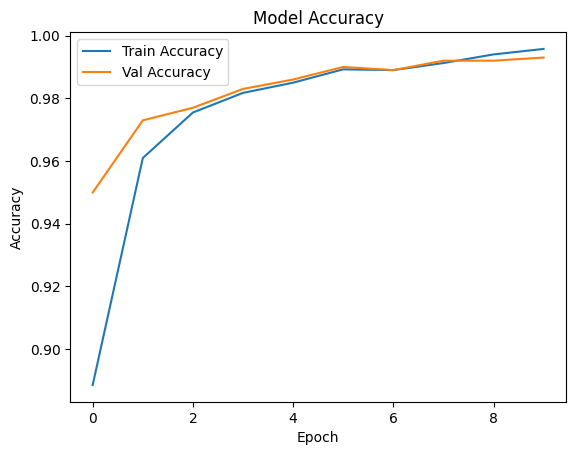

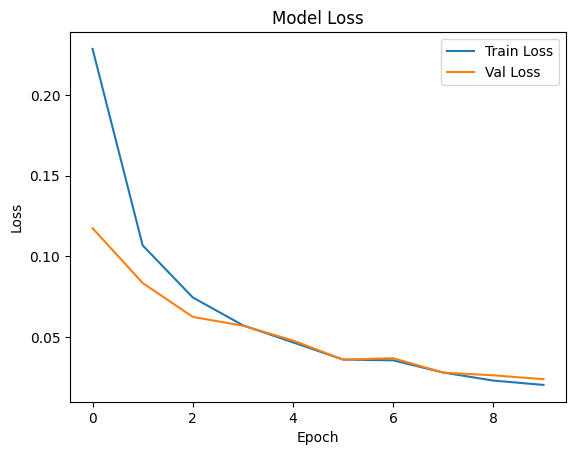

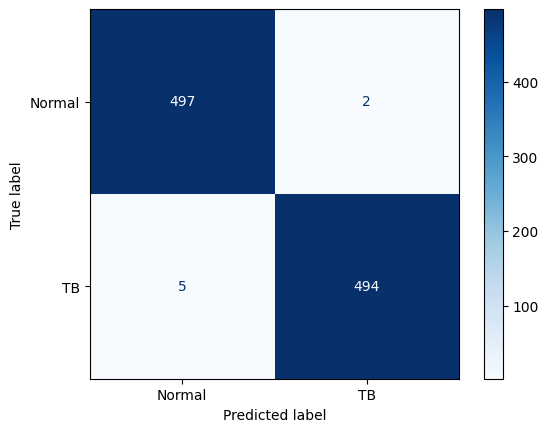

In [ ]:

def run_vgg16_pipeline(X_train, y_train, X_val, y_val):
    # Start MLflow experiment
    mlflow.set_experiment("TB Detection with TransferLearning")
    with mlflow.start_run(run_name="VGG16_Binary_Classifier"):

        # Log parameters
        mlflow.log_params({
            "base_model1": "VGG16",
            "include_top": False,
            "trainable_base": False,
            "dense_units": 128,
            "activation": "relu",
            "optimizer": "Adam",
            "loss": "binary_crossentropy",
            "epochs": 10,
            "batch_size": 32
        })

        # Load base model
        base_model1 = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))
        base_model1.trainable = False

        # Add custom head
        x = base_model1.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(128, activation='relu')(x)
        x = Dense(1, activation='sigmoid')(x)
        model1 = Model(inputs=base_model1.input, outputs=x)

        model1.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

        # Callbacks
        log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
        early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
        checkpoint = ModelCheckpoint('best_model1.h5', save_best_only=True)
        callbacks = [tensorboard_callback, early_stop, checkpoint]

        # Train model
        history1 = model1.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=10,
            batch_size=32,
            callbacks=callbacks
        )

        # Log per-epoch metrics
        for epoch in range(len(history1.history['loss'])):
            mlflow.log_metric("train_loss", history1.history['loss'][epoch], step=epoch)
            mlflow.log_metric("val_loss", history1.history['val_loss'][epoch], step=epoch)
            mlflow.log_metric("train_accuracy", history1.history['accuracy'][epoch], step=epoch)
            mlflow.log_metric("val_accuracy", history1.history['val_accuracy'][epoch], step=epoch)

        # Final evaluation
        loss, accuracy = model1.evaluate(X_val, y_val)
        mlflow.log_metric("final_val_loss", loss)
        mlflow.log_metric("final_val_accuracy", accuracy)

        # Save model
        model1.save("vgg16_tb_model.h5")
        mlflow.log_artifact("vgg16_tb_model.h5")

        # Accuracy plot
        plt.figure()
        plt.plot(history1.history['accuracy'], label='Train Accuracy')
        plt.plot(history1.history['val_accuracy'], label='Val Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.savefig("accuracy_plot.png")
        mlflow.log_artifact("accuracy_plot.png")

        # Loss plot
        plt.figure()
        plt.plot(history1.history['loss'], label='Train Loss')
        plt.plot(history1.history['val_loss'], label='Val Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.savefig("loss_plot.png")
        mlflow.log_artifact("loss_plot.png")

        # Predictions
        y_pred_probs = model1.predict(X_val)
        y_pred = (y_pred_probs > 0.5).astype(int).flatten()

        # Confusion matrix
        cm = confusion_matrix(y_val, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'TB'])
        disp.plot(cmap='Blues')
        plt.savefig("confusion_matrix.png")
        mlflow.log_artifact("confusion_matrix.png")

        # Classification report
        report = classification_report(y_val, y_pred, target_names=['Normal', 'TB'], output_dict=True)
        for label in report:
            if isinstance(report[label], dict):
                for metric in report[label]:
                    mlflow.log_metric(f"{label}_{metric}", report[label][metric])

        print(f"Validation Loss: {loss:.4f}")
        print(f"Validation Accuracy: {accuracy:.4f}")
        print(classification_report(y_val, y_pred, target_names=['Normal', 'TB']))


run_vgg16_pipeline(X_train, y_train, X_val, y_val)

In [ ]:
webbrowser.open("http://127.0.0.1:5000")


True

In [ ]:
# Load the Keras model
loaded_keras_model = tf.keras.models.load_model("vgg16_tb_model.h5") 

# Save the loaded model as a pickle file
with open("vgg16_tb_model", 'wb') as file:
    pickle.dump(loaded_keras_model, file)

print("Model successfully converted from .h5 to Pickle.")


Model successfully converted from .h5 to Pickle.


In [ ]:
with open('C:/Users/shanm/OneDrive/Desktop/project/tbprediction/vgg16_tb_model.pkl', 'rb') as file:
   model1_vgg = pickle.load(file)

path = "C:/Users/shanm/OneDrive/Desktop/project/tbprediction/preprocessed_dataset/test/NORMAL/others (14).jpg"
IMG_SIZE = (224, 224)

img = load_img(path, target_size=IMG_SIZE)
img_array = img_to_array(img) / 255.0

Z = np.expand_dims(img_array, axis=0)

# Predict using the loaded model
prediction_probabilities = model1_vgg.predict(Z)

# Convert probabilities to binary classification using a threshold (e.g., 0.5)
threshold > 0.5
binary_predictions = (prediction_probabilities > threshold).astype(int)

print("Prediction Probabilities:")
print(prediction_probabilities)
print("\nBinary Predictions (Threshold = 0.5):")
print(binary_predictions)
if binary_predictions==1:

   print("tb-positive")
else:
   print("tb-negative ")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
Prediction Probabilities:
[[0.38516754]]

Binary Predictions (Threshold = 0.5):
[[0]]
tb-negative 


In [ ]:
with open('C:/Users/shanm/OneDrive/Desktop/project/tbprediction/vgg16_tb_model.pkl', 'rb') as file:
   model1_vgg = pickle.load(file)

path = "C:/Users/shanm/OneDrive/Desktop/tb_xray.jpg"
IMG_SIZE = (224, 224)

img = load_img(path, target_size=IMG_SIZE)
img_array = img_to_array(img) / 255.0

# Ensure the image array has the correct shape for the VGG16 model (batch, height, width, channels)
Z = np.expand_dims(img_array, axis=0) 

# Predict using the loaded model
prediction_probabilities = model1_vgg.predict(Z)


threshold > 0.5
binary_predictions = (prediction_probabilities > threshold).astype(int)

print("Prediction Probabilities:")
print(prediction_probabilities)
print("\nBinary Predictions (Threshold = 0.5):")
print(binary_predictions)
if binary_predictions==1:

   print("tb-positive")
else:
   print("tb-negative ")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
Prediction Probabilities:
[[0.92304313]]

Binary Predictions (Threshold = 0.5):
[[1]]
tb-positive


Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.8747 - loss: 0.3217

125/125 ━━━━━━━━━━━━━━━━━━━━ 130s 973ms/step - accuracy: 0.8748 - loss: 0.3215 - val_accuracy: 0.9168 - val_loss: 0.2406
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8872 - loss: 0.2998

125/125 ━━━━━━━━━━━━━━━━━━━━ 625s 5s/step - accuracy: 0.8873 - loss: 0.2997 - val_accuracy: 0.9168 - val_loss: 0.2405
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 97s 780ms/step - accuracy: 0.8894 - loss: 0.2968 - val_accuracy: 0.9168 - val_loss: 0.2421
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 533ms/step - accuracy: 0.8912 - loss: 0.2903

125/125 ━━━━━━━━━━━━━━━━━━━━ 90s 724ms/step - accuracy: 0.8912 - loss: 0.2903 - val_accuracy: 0.9168 - val_loss: 0.2388
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 534ms/step - accuracy: 0.8878 - loss: 0.2950

125/125 ━━━━━━━━━━━━━━━━━━━━ 85s 680ms/step - accuracy: 0.8879 - loss: 0.2949 - val_accuracy: 0.9168 - val_loss: 0.2388
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - accuracy: 0.8958 - loss: 0.2808

125/125 ━━━━━━━━━━━━━━━━━━━━ 85s 679ms/step - accuracy: 0.8957 - loss: 0.2808 - val_accuracy: 0.9168 - val_loss: 0.2387
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 83s 665ms/step - accuracy: 0.8980 - loss: 0.2791 - val_accuracy: 0.9168 - val_loss: 0.2471
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 93s 747ms/step - accuracy: 0.8887 - loss: 0.2875 - val_accuracy: 0.9168 - val_loss: 0.2407
Epoch 9/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 105s 842ms/step - accuracy: 0.8943 - loss: 0.2797 - val_accuracy: 0.9168 - val_loss: 0.2391
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 514ms/step - accuracy: 0.9202 - loss: 0.2275


32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 578ms/step
Validation Loss: 0.2387
Validation Accuracy: 0.9168
              precision    recall  f1-score   support

      Normal       1.00      0.83      0.91       499
          TB       0.86      1.00      0.92       499

    accuracy                           0.92       998
   macro avg       0.93      0.92      0.92       998
weighted avg       0.93      0.92      0.92       998



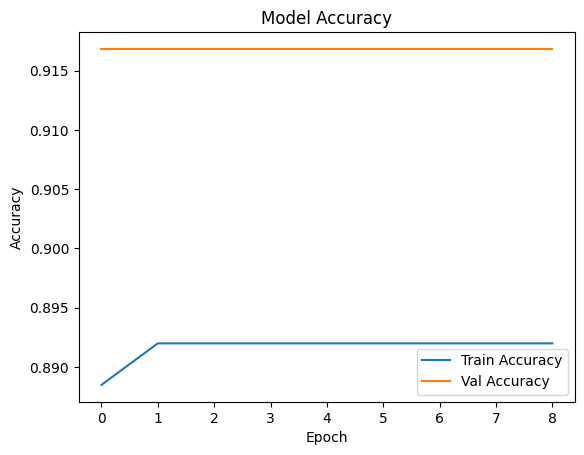

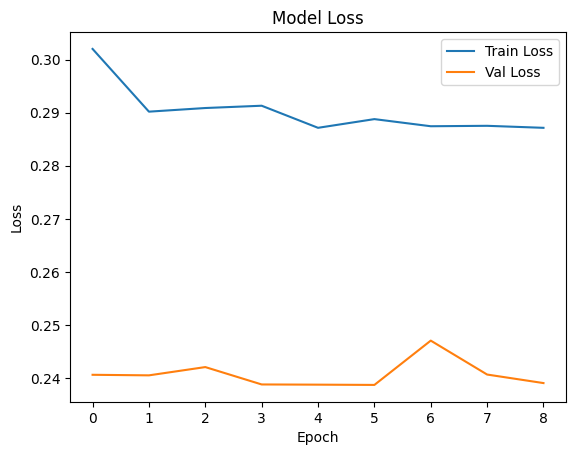

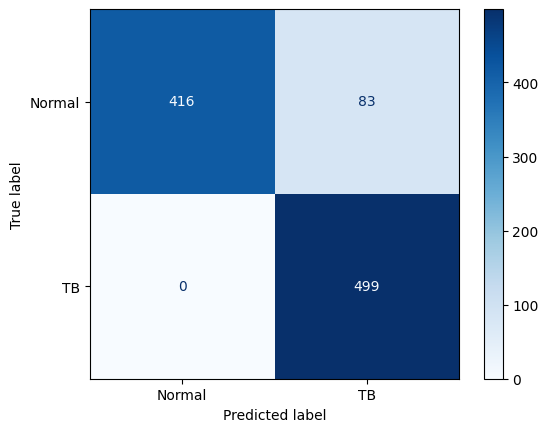

In [ ]:
def run_EfficientNetB0_pipeline(X_train, y_train, X_val, y_val):
    # Start MLflow experiment
    mlflow.set_experiment("TB Detection with TransferLearning")
    with mlflow.start_run(run_name="EfficientNetB0_Binary_Classifier"):

        # Log parameters
        mlflow.log_params({
            "base_model1": "EfficientNetB0",
            "include_top": False,
            "trainable_base": False,
            "dense_units": 128,
            "activation": "relu",
            "optimizer": "Adam",
            "loss": "binary_crossentropy",
            "epochs": 20,
            "batch_size": 32
        })

        # Load base model
        base_model1 = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))
        base_model1.trainable = False

        # Add custom head
        x = base_model1.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(128, activation='relu')(x)
        x = Dense(1, activation='sigmoid')(x)
        model1 = Model(inputs=base_model1.input, outputs=x)

        model1.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

        # Callbacks
        log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
        early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        checkpoint = ModelCheckpoint('best_model1.h5', save_best_only=True)
        callbacks = [tensorboard_callback, early_stop, checkpoint]

        # Train model
        history1 = model1.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=20,
            batch_size=32,
            callbacks=callbacks
        )

        # Log per-epoch metrics
        for epoch in range(len(history1.history['loss'])):
            mlflow.log_metric("train_loss", history1.history['loss'][epoch], step=epoch)
            mlflow.log_metric("val_loss", history1.history['val_loss'][epoch], step=epoch)
            mlflow.log_metric("train_accuracy", history1.history['accuracy'][epoch], step=epoch)
            mlflow.log_metric("val_accuracy", history1.history['val_accuracy'][epoch], step=epoch)

        # Final evaluation
        loss, accuracy = model1.evaluate(X_val, y_val)
        mlflow.log_metric("final_val_loss", loss)
        mlflow.log_metric("final_val_accuracy", accuracy)

        # Save model
        model1.save("EfficientNetB0_tb_model.h5")
        mlflow.log_artifact("EfficientNetB0_tb_model.h5")


        # Accuracy plot
        plt.figure()
        plt.plot(history1.history['accuracy'], label='Train Accuracy')
        plt.plot(history1.history['val_accuracy'], label='Val Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.savefig("accuracy_plot.png")
        mlflow.log_artifact("accuracy_plot.png")

        # Loss plot
        plt.figure()
        plt.plot(history1.history['loss'], label='Train Loss')
        plt.plot(history1.history['val_loss'], label='Val Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.savefig("loss_plot.png")
        mlflow.log_artifact("loss_plot.png")

        # Predictions
        y_pred_probs = model1.predict(X_val)
        y_pred = (y_pred_probs > 0.5).astype(int).flatten()

        # Confusion matrix
        cm = confusion_matrix(y_val, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'TB'])
        disp.plot(cmap='Blues')
        plt.savefig("confusion_matrix.png")
        mlflow.log_artifact("confusion_matrix.png")

        # Classification report
        report = classification_report(y_val, y_pred, target_names=['Normal', 'TB'], output_dict=True)
        for label in report:
            if isinstance(report[label], dict):
                for metric in report[label]:
                    mlflow.log_metric(f"{label}_{metric}", report[label][metric])

        print(f"Validation Loss: {loss:.4f}")
        print(f"Validation Accuracy: {accuracy:.4f}")
        print(classification_report(y_val, y_pred, target_names=['Normal', 'TB']))


run_EfficientNetB0_pipeline(X_train, y_train, X_val, y_val)

Epoch 1/18
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8948 - loss: 0.3056

125/125 ━━━━━━━━━━━━━━━━━━━━ 247s 2s/step - accuracy: 0.8948 - loss: 0.3055 - val_accuracy: 0.9168 - val_loss: 0.2310
Epoch 2/18
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8923 - loss: 0.2813

125/125 ━━━━━━━━━━━━━━━━━━━━ 299s 2s/step - accuracy: 0.8923 - loss: 0.2813 - val_accuracy: 0.9168 - val_loss: 0.2183
Epoch 3/18
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8929 - loss: 0.2697

125/125 ━━━━━━━━━━━━━━━━━━━━ 251s 2s/step - accuracy: 0.8929 - loss: 0.2697 - val_accuracy: 0.9168 - val_loss: 0.2090
Epoch 4/18
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8934 - loss: 0.2521

125/125 ━━━━━━━━━━━━━━━━━━━━ 297s 2s/step - accuracy: 0.8934 - loss: 0.2521 - val_accuracy: 0.9168 - val_loss: 0.2030
Epoch 5/18
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8906 - loss: 0.2457

125/125 ━━━━━━━━━━━━━━━━━━━━ 307s 2s/step - accuracy: 0.8907 - loss: 0.2457 - val_accuracy: 0.9198 - val_loss: 0.1915
Epoch 6/18
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8958 - loss: 0.2324

125/125 ━━━━━━━━━━━━━━━━━━━━ 275s 2s/step - accuracy: 0.8958 - loss: 0.2324 - val_accuracy: 0.9178 - val_loss: 0.1764
Epoch 7/18
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9023 - loss: 0.2243

125/125 ━━━━━━━━━━━━━━━━━━━━ 263s 2s/step - accuracy: 0.9023 - loss: 0.2243 - val_accuracy: 0.9178 - val_loss: 0.1736
Epoch 8/18
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9071 - loss: 0.1978

125/125 ━━━━━━━━━━━━━━━━━━━━ 304s 2s/step - accuracy: 0.9071 - loss: 0.1978 - val_accuracy: 0.9208 - val_loss: 0.1586
Epoch 9/18
125/125 ━━━━━━━━━━━━━━━━━━━━ 322s 3s/step - accuracy: 0.9119 - loss: 0.2020 - val_accuracy: 0.9499 - val_loss: 0.1717
Epoch 10/18
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9296 - loss: 0.1692

125/125 ━━━━━━━━━━━━━━━━━━━━ 354s 3s/step - accuracy: 0.9296 - loss: 0.1692 - val_accuracy: 0.9479 - val_loss: 0.1414
Epoch 11/18
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9319 - loss: 0.1647

125/125 ━━━━━━━━━━━━━━━━━━━━ 367s 3s/step - accuracy: 0.9319 - loss: 0.1647 - val_accuracy: 0.9519 - val_loss: 0.1243
Epoch 12/18
125/125 ━━━━━━━━━━━━━━━━━━━━ 371s 3s/step - accuracy: 0.9283 - loss: 0.1576 - val_accuracy: 0.9289 - val_loss: 0.1339
Epoch 13/18
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9418 - loss: 0.1400

125/125 ━━━━━━━━━━━━━━━━━━━━ 365s 3s/step - accuracy: 0.9418 - loss: 0.1400 - val_accuracy: 0.9439 - val_loss: 0.1065
Epoch 14/18
125/125 ━━━━━━━━━━━━━━━━━━━━ 344s 3s/step - accuracy: 0.9500 - loss: 0.1294 - val_accuracy: 0.9289 - val_loss: 0.1364
Epoch 15/18
125/125 ━━━━━━━━━━━━━━━━━━━━ 366s 3s/step - accuracy: 0.9446 - loss: 0.1317 - val_accuracy: 0.9399 - val_loss: 0.1188
Epoch 16/18
125/125 ━━━━━━━━━━━━━━━━━━━━ 338s 3s/step - accuracy: 0.9512 - loss: 0.1115 - val_accuracy: 0.9429 - val_loss: 0.1633
32/32 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.9394 - loss: 0.1102


32/32 ━━━━━━━━━━━━━━━━━━━━ 88s 3s/step
Validation Loss: 0.1065
Validation Accuracy: 0.9439
              precision    recall  f1-score   support

      Normal       0.99      0.90      0.94       499
          TB       0.91      0.99      0.95       499

    accuracy                           0.94       998
   macro avg       0.95      0.94      0.94       998
weighted avg       0.95      0.94      0.94       998



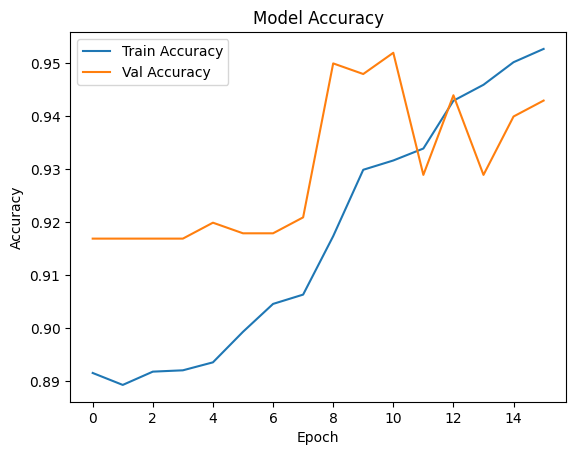

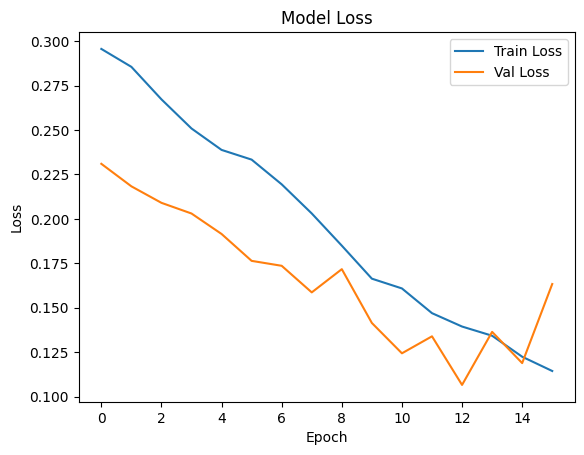

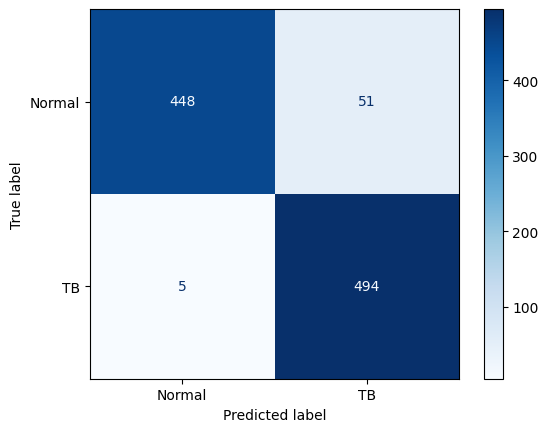

In [21]:

def run_ResNet50_pipeline(X_train, y_train, X_val, y_val):
    # Start MLflow experiment
    mlflow.set_experiment("TB Detection with TransferLearning")
    with mlflow.start_run(run_name="ResNet50_Binary_Classifier"):

        # Log parameters
        mlflow.log_params({
            "base_model1": "ResNet50",
            "include_top": False,
            "trainable_base": False,
            "dense_units": 128,
            "activation": "relu",
            "optimizer": "Adam",
            "loss": "binary_crossentropy",
            "epochs": 18,
            "batch_size": 32
        })

        # Load base model
        base_model1 = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))
        base_model1.trainable = False

        # Add custom head
        x = base_model1.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(128, activation='relu')(x)
        x = Dense(1, activation='sigmoid')(x)
        model1 = Model(inputs=base_model1.input, outputs=x)

        model1.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

        # Callbacks
        log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
        early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        checkpoint = ModelCheckpoint('best_model1.h5', save_best_only=True)
        callbacks = [tensorboard_callback, early_stop, checkpoint]

        # Train model
        history1 = model1.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=18,
            batch_size=32,
            callbacks=callbacks
        )

        # Log per-epoch metrics
        for epoch in range(len(history1.history['loss'])):
            mlflow.log_metric("train_loss", history1.history['loss'][epoch], step=epoch)
            mlflow.log_metric("val_loss", history1.history['val_loss'][epoch], step=epoch)
            mlflow.log_metric("train_accuracy", history1.history['accuracy'][epoch], step=epoch)
            mlflow.log_metric("val_accuracy", history1.history['val_accuracy'][epoch], step=epoch)

        # Final evaluation
        loss, accuracy = model1.evaluate(X_val, y_val)
        mlflow.log_metric("final_val_loss", loss)
        mlflow.log_metric("final_val_accuracy", accuracy)

        # Save model
        model1.save("ResNet50_tb_model.h5")
        mlflow.log_artifact("ResNet50_tb_model.h5")


        # Accuracy plot
        plt.figure()
        plt.plot(history1.history['accuracy'], label='Train Accuracy')
        plt.plot(history1.history['val_accuracy'], label='Val Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.savefig("accuracy_plot.png")
        mlflow.log_artifact("accuracy_plot.png")

        # Loss plot
        plt.figure()
        plt.plot(history1.history['loss'], label='Train Loss')
        plt.plot(history1.history['val_loss'], label='Val Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.savefig("loss_plot.png")
        mlflow.log_artifact("loss_plot.png")

        # Predictions
        y_pred_probs = model1.predict(X_val)
        y_pred = (y_pred_probs > 0.5).astype(int).flatten()

        # Confusion matrix
        cm = confusion_matrix(y_val, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'TB'])
        disp.plot(cmap='Blues')
        plt.savefig("confusion_matrix.png")
        mlflow.log_artifact("confusion_matrix.png")

        # Classification report
        report = classification_report(y_val, y_pred, target_names=['Normal', 'TB'], output_dict=True)
        for label in report:
            if isinstance(report[label], dict):
                for metric in report[label]:
                    mlflow.log_metric(f"{label}_{metric}", report[label][metric])

        print(f"Validation Loss: {loss:.4f}")
        print(f"Validation Accuracy: {accuracy:.4f}")
        print(classification_report(y_val, y_pred, target_names=['Normal', 'TB']))


run_ResNet50_pipeline(X_train, y_train, X_val, y_val)